In [153]:
import scipy         
import datetime
from scipy.linalg import expm,det
import scipy.sparse as sparse
from quspin.operators import hamiltonian, commutator, exp_op # Hamiltonians and operators
from quspin.basis import tensor_basis, spin_basis_1d # bases
import numpy as np # general math functions
import matplotlib.pyplot as plt # plotting library
from numba import jit
from scipy.integrate import solve_ivp,odeint
from functools import reduce
import datetime


In [154]:
L = 4 #system size
M = 0.1 #fermion mass
N=3 #number of layers
l=1 #spin length
m_epsilon = 0
no_checks = dict(check_pcon=False,check_symm=False,check_herm=False)

In [155]:
#construct basis
basis=spin_basis_1d(L=L,S = str(l))
print(basis)

reference states: 
array index   /   Fock state   /   integer repr. 
      0.         |2 2 2 2>           80  
      1.         |2 2 2 1>           79  
      2.         |2 2 2 0>           78  
      3.         |2 2 1 2>           77  
      4.         |2 2 1 1>           76  
      5.         |2 2 1 0>           75  
      6.         |2 2 0 2>           74  
      7.         |2 2 0 1>           73  
      8.         |2 2 0 0>           72  
      9.         |2 1 2 2>           71  
     10.         |2 1 2 1>           70  
     11.         |2 1 2 0>           69  
     12.         |2 1 1 2>           68  
     13.         |2 1 1 1>           67  
     14.         |2 1 1 0>           66  
     15.         |2 1 0 2>           65  
     16.         |2 1 0 1>           64  
     17.         |2 1 0 0>           63  
     18.         |2 0 2 2>           62  
     19.         |2 0 2 1>           61  
     20.         |2 0 2 0>           60  
     21.         |2 0 1 2>           59  
     22

In [156]:
#initialisation of the Gauss laws
LL = 3 #number of sites-1
liste = []
liste_m = []
gauss_law_map = []
Gauss_law = []
gauss_law_matrix = []


for i in range(L+1):
    liste.append([[1.,i]])
    liste_m.append([[-1.,i]])
    
    
gauss_law_map.append([
    ["z",liste[0]],
    ["z",liste[3]],
])

gauss_law_map.append([
    ["z",liste[1]],
    ["z",liste_m[0]],
    ["I",liste[1]],
])

gauss_law_map.append([
    ["z",liste_m[2]],
    ["z",liste_m[1]],
])

gauss_law_map.append([
    ["z",liste_m[3]],
    ["z",liste[2]],
    ["I",liste[3]],
])

for i in range(LL+1):
    Gauss_law.append(hamiltonian(gauss_law_map[i],dynamic_list=[],basis=basis,**no_checks))
for i in range(LL+1):
    gauss_law_matrix.append(Gauss_law[i].tocsc())

In [157]:
B = np.zeros((4*l+1,4*l+1))
for i in range(4*l+1):
    for j in range(4*l+1):
        B[i][j] = (-2*l+i)**j
b = np.zeros(4*l+1)
b[2*l+1] = 1.
solution = scipy.linalg.solve(B,b)
y = np.zeros(4*3+1)
for i in range(4*l+1):
    y[i] = solution[i]
print(y)
print(b)

[ 0.          0.66666667  0.66666667 -0.16666667 -0.16666667  0.
  0.          0.          0.          0.          0.          0.
  0.        ]
[0. 0. 0. 1. 0.]


In [158]:
C = np.zeros((4*l+1,4*l+1))
for i in range(4*l+1):
    for j in range(4*l+1):
        C[i][j] = (-2*l+i+1)**j
c = np.zeros(4*l+1)
c[2*l] = 1.
solution = scipy.linalg.solve(C,c)
z = np.zeros(4*3+1)
for i in range(4*l+1):
    z[i] = solution[i]
print(z)
print(c)

[ 0.    1.5   0.25 -1.    0.25  0.    0.    0.    0.    0.    0.    0.
  0.  ]
[0. 0. 1. 0. 0.]


In [159]:
#projectors on g=1 for every site
Proj = [sparse.csc_matrix((basis.Ns,basis.Ns)) for i in range(LL+1)]
for i in range(int(LL/2)+1):
    for j in range(4*l+1):
        Proj[2*i] += y[j]*gauss_law_matrix[2*i]**j
for i in range(int(LL/2)+1):
    for j in range(4*l+1):
        Proj[2*i+1] += z[j]*gauss_law_matrix[2*i+1]**j

In [160]:
A = np.zeros((2*l+1,2*l+1))
for i in range(2*l+1):
    for j in range(2*l+1):
        A[i][j] = (-l+i)**j
a = np.zeros(2*l+1)
for i in range(2*l+1):
    a[i] = (-1)**(-l+i)
solution = scipy.linalg.solve(A,a)
x = np.zeros(2*3+1)
for i in range(2*l+1):
    x[i] = solution[i]
print(x)

[ 1.  0. -2.  0.  0.  0.  0.]


In [161]:
D = np.zeros((4*l+1,4*l+1))
for i in range(4*l+1):
    for j in range(4*l+1):
        D[i][j] = (-2*l+i)**j
d = np.zeros(4*l+1)
d[2*l] = 1.
solution = scipy.linalg.solve(D,d)
dd = np.zeros(4*3+1)
for i in range(4*l+1):
    dd[i] = solution[i]
print(dd)
print(d)

[ 1.    0.   -1.25 -0.    0.25  0.    0.    0.    0.    0.    0.    0.
  0.  ]
[0. 0. 1. 0. 0.]


In [162]:
E = np.zeros((4*l+1,4*l+1))
for i in range(4*l+1):
    for j in range(4*l+1):
        E[i][j] = (-2*l+i+1)**j
e = np.zeros(4*l+1)
e[2*l-1] = 1.
solution = scipy.linalg.solve(E,e)
ee = np.zeros(4*3+1)
for i in range(4*l+1):
    ee[i] = solution[i]
print(ee)
print(e)

[ 1.         -0.83333333 -0.83333333  0.83333333 -0.16666667  0.
  0.          0.          0.          0.          0.          0.
  0.        ]
[0. 1. 0. 0. 0.]


In [163]:
#projectors on g=0 for every site
Proj_0 = [sparse.csc_matrix((basis.Ns,basis.Ns)) for i in range(LL+1)]
for i in range(int(LL/2)+1):
    for j in range(4*l+1):
        Proj_0[2*i] += dd[j]*gauss_law_matrix[2*i]**j
for i in range(int(LL/2)+1):
    for j in range(4*l+1):
        Proj_0[2*i+1] += ee[j]*gauss_law_matrix[2*i+1]**j

In [164]:
const_term = []
linear_term = []
quadratic_term = []
cubic_term = []
quartic_term = []
quintic_term = []
sextic_term = []

interaction_p = []
interaction_m = []

phase = []
phase_ham = []

link_p = []
link_p_ham = []

link_m = []
link_m_ham = []

for i in range(L):
    const_term.append([[x[0],i]])
    linear_term.append([[x[1],i]])
    quadratic_term.append([[x[2],i,i]])
    cubic_term.append([[x[3],i,i,i]])
    quartic_term.append([[x[4],i,i,i,i]])
    quintic_term.append([[x[5],i,i,i,i,i]])
    sextic_term.append([[x[6],i,i,i,i,i,i]])


    phase.append([
        ["I", const_term[i]],
        ["z", linear_term[i]],
        ["zz", quadratic_term[i]],
        ["zzz", cubic_term[i]],
        ["zzzz", quartic_term[i]],
        ["zzzzz", quintic_term[i]],
        ["zzzzzz", sextic_term[i]],

    ])
    
    link_p.append([
    ["+",[[1./np.sqrt(l*(l+1)),i]]]  
    ])      
    
    link_m.append([
    ["-",[[1./np.sqrt(l*(l+1)),i]]]           
        
    ])
    
    phase_ham.append(hamiltonian(phase[i],dynamic_list=[],basis=basis,**no_checks))
    link_p_ham.append(hamiltonian(link_p[i],dynamic_list=[],basis=basis,**no_checks))
    link_m_ham.append(hamiltonian(link_m[i],dynamic_list=[],basis=basis,**no_checks))


    


kin_energy = [[0.5,i,i] for i in range(L)]

mass_term = []
mass_term.append([2*(-1)**0*M,0])
mass_term.append([2*(-1)**1*M,1])
mass_term.append([2*(-1)**1*M,2])
mass_term.append([2*(-1)**0*M,3])


kin_mass_map = [
            ["zz", kin_energy], 
            ["z", mass_term], 
]

interaction = [sparse.csc_matrix((basis.Ns,basis.Ns)) for i in range(L)]

interaction[0] = -0.5*(Proj[0]@phase_ham[0].tocsc()@link_p_ham[0].tocsc()@Proj[1]+Proj[1]@link_m_ham[0].tocsc()@phase_ham[0].tocsc()@Proj[0])
interaction[1] = 0.5*(Proj[1]@phase_ham[1].tocsc()@link_p_ham[1].tocsc()@Proj[2]+Proj[2]@link_m_ham[1].tocsc()@phase_ham[1].tocsc()@Proj[1])
interaction[2] = 0.5*(Proj[3]@phase_ham[1].tocsc()@phase_ham[2].tocsc()@link_p_ham[2].tocsc()@Proj[2]+Proj[2]@link_m_ham[2].tocsc()@phase_ham[2].tocsc()@phase_ham[1].tocsc()@Proj[3])
interaction[3] = -0.5*(Proj[0]@phase_ham[0].tocsc()@phase_ham[3].tocsc()@link_p_ham[3].tocsc()@Proj[3]+Proj[3]@link_m_ham[3].tocsc()@phase_ham[3].tocsc()@phase_ham[0].tocsc()@Proj[0])

plaquette = [sparse.csc_matrix((basis.Ns,basis.Ns)) for i in range(2)]

plaquette[0] = 0.5*(Proj_0[3]@phase_ham[0].tocsc()@phase_ham[1].tocsc()@phase_ham[2].tocsc()@phase_ham[3].tocsc()@link_p_ham[0].tocsc()@link_p_ham[1].tocsc()@link_m_ham[2].tocsc()@link_m_ham[3].tocsc()@Proj_0[3]+Proj_0[3]@link_p_ham[2].tocsc()@link_p_ham[3].tocsc()@link_m_ham[0].tocsc()@link_m_ham[1].tocsc()@phase_ham[0].tocsc()@phase_ham[1].tocsc()@phase_ham[2].tocsc()@phase_ham[3].tocsc()@Proj_0[3])

plaquette[1] = -0.5*(Proj[3]@phase_ham[0].tocsc()@phase_ham[1].tocsc()@phase_ham[2].tocsc()@phase_ham[3].tocsc()@link_p_ham[0].tocsc()@link_p_ham[1].tocsc()@link_m_ham[2].tocsc()@link_m_ham[3].tocsc()@Proj[3]+Proj[3]@link_p_ham[2].tocsc()@link_p_ham[3].tocsc()@link_m_ham[0].tocsc()@link_m_ham[1].tocsc()@phase_ham[0].tocsc()@phase_ham[1].tocsc()@phase_ham[2].tocsc()@phase_ham[3].tocsc()@Proj[3])

h_plaq = 0

for i in range(2):
    h_plaq += plaquette[i]

H_kin_mass = hamiltonian(kin_mass_map,dynamic_list=[],basis=basis,**no_checks)
h_kin_mass = H_kin_mass.tocsc()

h_int = 0

for i in range(L):
    h_int += interaction[i]


full_ham_matrix = h_kin_mass + h_plaq + h_int #Spin-1 Hamiltonian without the local contstaints

for i in range(LL+1):
    full_ham_matrix = (Proj_0[i]+Proj[i])@full_ham_matrix@(Proj_0[i]+Proj[i])

G=0
for i in range(LL+1):
    G += 10*(Gauss_law[i]**2-Gauss_law[i])**2
constraint_full_matrix = G.tocsc()
constrained_full_ham_matrix= full_ham_matrix + constraint_full_matrix #Spin-1 Hamiltonian with the local contstaints as a penalty term


In [165]:
#eigenvalues and eigenvectors of the Spin-1 Hamiltonian without the local contstaints
eigenval, eigenvec = scipy.sparse.linalg.eigsh(full_ham_matrix,k = 3,which = "SA")
string = ""
print(eigenval[eigenval<=1e1])
for i in range(basis.Ns):
    if np.abs(eigenvec[:,0][i])>=1e-5:
        string+=str(eigenvec[:,0][i])+basis.int_to_state(basis.Ns-i-1)+"\n"

[-9.29176933e-01 -3.13068105e-01 -5.53868278e-16]


In [166]:
eigenvalues, eigenvectors = scipy.sparse.linalg.eigsh(constrained_full_ham_matrix,k = 3,which = "SA")


In [167]:
#Gauge invariant part of the spectrum
string = ""
print(eigenvalues[eigenvalues<=1e1])
for i in range(basis.Ns):
    if np.abs(eigenvectors[:,0][i])>=1e-4:
        string+=str(eigenvectors[:,0][i])+basis.int_to_state(basis.Ns-i-1)+"\n"
        #for j in range(basis.Ns):
            #if (np.abs(np.abs(eigenvectors[:,0][i])-np.abs(eigenvectors[:,0][j]))<=1e-5) & (i<j):
                #print(basis.int_to_state(basis.Ns-i-1),basis.int_to_state(basis.Ns-j-1))
print(string)


[-0.92917693 -0.31306811  0.49289322]
(0.03457217443987806+0.05974970161140723j)|2 2 0 1>
(-0.07812323718038307-0.1350172555261853j)|2 2 0 0>
(0.14144457565800697+0.24445298356382897j)|2 1 1 1>
(-0.037775085745836066-0.06528516468015796j)|2 1 0 1>
(-0.03457217443987814-0.05974970161140754j)|2 1 0 0>
(0.1414445756579956+0.24445298356381878j)|1 1 1 2>
(-0.3885292196138894-0.6714794575508111j)|1 1 1 1>
(0.14144457565800653+0.24445298356382758j)|1 1 0 1>
(-0.0345721744398857-0.0597497016114133j)|1 0 2 2>
(-0.037775085745819906-0.06528516468014624j)|1 0 1 2>
(0.14144457565799587+0.24445298356381942j)|1 0 1 1>
(-0.07812323718038633-0.13501725552618724j)|0 0 2 2>
(0.03457217443988563+0.05974970161141276j)|0 0 1 2>



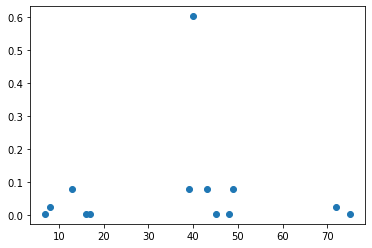

In [168]:
yy = []
xx = []
for i in range(basis.Ns):
    if np.abs(eigenvectors[:,0][i])**2>=1e-4:
        yy.append(np.abs(eigenvectors[:,0][i])**2) 
        xx.append(i)
plt.plot(xx,yy, "o")

In [169]:
def rot_sigma(k,i,j,phi,theta):
    if k>=L:
        print("Warning! Rotations apply to k<=L-1!")
    sigma = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma[2*l-i][2*l-j] = 0.5*(np.cos(phi)+1j*np.sin(phi))
    sigma[2*l-j][2*l-i] = 0.5*(np.cos(phi)-1j*np.sin(phi))
    sigma = sparse.csc_matrix(sigma)
    rot_matrix = expm(-1j*theta*sigma)
    if k==0:
        tensprod = rot_matrix
        for i in range(L-1):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    else:
        tensprod = sparse.identity(2*l+1)
        for i in range(1,k):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
        tensprod = scipy.sparse.kron(tensprod,rot_matrix)
        for i in range(k+1,L):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    return tensprod


def rot_sigma_e(i,j,phi,theta):
    sigma_e = sparse.identity(basis.Ns,dtype = complex)
    sigma_e = rot_sigma(0,i,j,phi,theta)@rot_sigma(3,i,j,phi,theta)
    return(sigma_e)

def rot_sigma_o(i,j,phi,theta):
    sigma_o = sparse.identity(basis.Ns,dtype = complex)
    sigma_o = rot_sigma(1,i,j,phi,theta)@rot_sigma(2,i,j,phi,theta)
    return(sigma_o)



def sigma(k,i,j,phi):
    sigma = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma[2*l-i][2*l-j] = 0.5*(np.cos(phi)+1j*np.sin(phi))
    sigma[2*l-j][2*l-i] = 0.5*(np.cos(phi)-1j*np.sin(phi))
    sigma = sparse.csc_matrix(sigma)
    if k==0:
        tensprod = sigma
        for i in range(L-1):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    else:
        tensprod = sparse.identity(2*l+1)
        for i in range(1,k):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
        tensprod = scipy.sparse.kron(tensprod,sigma)
        for i in range(k+1,L):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    return tensprod


def sigma_e(i,j,phi):
    sigma_e = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    sigma_e = sparse.csc_matrix(sigma_e)
    sigma_e = sigma(0,i,j,phi) + sigma(3,i,j,phi)
    return sigma_e

def sigma_o(i,j,phi):
    sigma_o = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    sigma_o = sparse.csc_matrix(sigma_o)
    sigma_o = sigma(1,i,j,phi) + sigma(2,i,j,phi)
    return sigma_o




In [170]:
def ham_ms(n,m):
    sigma = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma[2*l-1][2*l-2] = 0.5
    sigma[2*l-2][2*l-1] = 0.5
    sigma = sparse.csc_matrix(sigma)
    summe = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    for k in range(L):
        
        if k == 0:
            tensprod = sigma
            for m in range(L-1):
                tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
            tensprod = tensprod.toarray()
        else:
            tensprod = sparse.identity(2*l+1)
            for i in range(1,k):
                tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
            tensprod = scipy.sparse.kron(tensprod,sigma)
            for i in range(k+1,L):
                tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
            tensprod = tensprod.toarray()
        if k == n:
            summe +=tensprod
        if k == m:
            summe +=tensprod

    return summe@summe

In [171]:
ms_01_eigenval, ms_01_eigenvec = scipy.linalg.eigh(ham_ms(0,1))
ms_12_eigenval, ms_12_eigenvec = scipy.linalg.eigh(ham_ms(1,2))
ms_23_eigenval, ms_23_eigenvec = scipy.linalg.eigh(ham_ms(2,3))
ms_03_eigenval, ms_03_eigenvec = scipy.linalg.eigh(ham_ms(0,3))


def rot_ms_01(theta):
    return ms_01_eigenvec@np.diag(np.exp(-1j*ms_01_eigenval*theta))@ms_01_eigenvec.T.conj()
def rot_ms_12(theta):
    return ms_12_eigenvec@np.diag(np.exp(-1j*ms_12_eigenval*theta))@ms_12_eigenvec.T.conj()
def rot_ms_23(theta):
    return ms_23_eigenvec@np.diag(np.exp(-1j*ms_23_eigenval*theta))@ms_23_eigenvec.T.conj()
def rot_ms_03(theta):
    return ms_03_eigenvec@np.diag(np.exp(-1j*ms_03_eigenval*theta))@ms_03_eigenvec.T.conj()

In [172]:
np.allclose(rot_ms_03(np.pi/3)@rot_ms_03(np.pi/3).T.conj(),np.identity(basis.Ns,dtype = complex),atol = 1e-5,rtol = 1e-5)

True

In [173]:

def ms_hamiltonian(i,j,phi):
    sigma = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma[2*l-i][2*l-j] = 0.5*(np.cos(phi)+1j*np.sin(phi))
    sigma[2*l-j][2*l-i] = 0.5*(np.cos(phi)-1j*np.sin(phi))
    sigma = sparse.csc_matrix(sigma)
    summe = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    for k in range(L):
        if k == 0:
            tensprod = sigma
            for m in range(L-1):
                tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
            tensprod = tensprod.toarray()
        else:
            tensprod = sparse.identity(2*l+1)
            for i in range(1,k):
                tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
            tensprod = scipy.sparse.kron(tensprod,sigma)
            for i in range(k+1,L):
                tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
            tensprod = tensprod.toarray()
        summe +=tensprod
    return summe@summe
                
matrix_part = ms_hamiltonian(1,2,0)
ms_ham_eigenval, ms_ham_eigenvec = scipy.linalg.eigh(matrix_part)




def ms_gate_global(theta):
    exponential = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    for i in range(basis.Ns):
        exponential[i][i] = np.exp(-1j*ms_ham_eigenval[i]*theta)
    exponential = scipy.sparse.csc_matrix(exponential)
    return ms_ham_eigenvec@exponential@ms_ham_eigenvec.T.conj()


def ms_hamiltonian_2(i,j,phi):
    sigma = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma[2*l-i][2*l-j] = 0.5*(np.cos(phi)+1j*np.sin(phi))
    sigma[2*l-j][2*l-i] = 0.5*(np.cos(phi)-1j*np.sin(phi))
    sigma = sparse.csc_matrix(sigma)
    summe = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    for k in range(L):
        if k == 0:
            tensprod = sigma
            for m in range(L-1):
                tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
            tensprod = tensprod.toarray()
        else:
            tensprod = sparse.identity(2*l+1)
            for i in range(1,k):
                tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
            tensprod = scipy.sparse.kron(tensprod,sigma)
            for i in range(k+1,L):
                tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
            tensprod = tensprod.toarray()
        summe +=tensprod
    return summe@summe@summe@summe
                
matrix_part_2 = ms_hamiltonian_2(1,2,0)
ms_ham_eigenval_2, ms_ham_eigenvec_2 = scipy.linalg.eigh(matrix_part_2)




def ms_gate_global_2(theta):
    exponential = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    for i in range(basis.Ns):
        exponential[i][i] = np.exp(-1j*ms_ham_eigenval_2[i]*theta)
    exponential = scipy.sparse.csc_matrix(exponential)
    return ms_ham_eigenvec_2@exponential@ms_ham_eigenvec_2.T.conj()


    
    
    
    
def ms_hamiltonian_1(i,j,phi):
    sigma_p = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma_m = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma_z = np.zeros((2*l+1,2*l+1),dtype = complex)
    
    sigma_p[2*l-j][2*l-i] = 1.
    sigma_m[2*l-i][2*l-j] = 1.
    
    sigma_z[2*l-i][2*l-i] = 1.
    sigma_z[2*l-j][2*l-j] = -1.
    
    sigma_p = sparse.csc_matrix(sigma_p)
    sigma_m = sparse.csc_matrix(sigma_m)
    sigma_z = sparse.csc_matrix(sigma_z)

    sigma_big_p = [np.zeros((basis.Ns,basis.Ns),dtype = complex) for n in range(L)]
    sigma_big_m = [np.zeros((basis.Ns,basis.Ns),dtype = complex) for n in range(L)]
    sigma_big_z = [np.zeros((basis.Ns,basis.Ns),dtype = complex) for n in range(L)]

    summe = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    
    for k in range(L):
        if k == 0:
            tensprod_p = sigma_p
            tensprod_m = sigma_m
            tensprod_z = sigma_z

            for m in range(L-1):
                tensprod_p = scipy.sparse.kron(tensprod_p,sparse.identity(2*l+1))
                tensprod_m = scipy.sparse.kron(tensprod_m,sparse.identity(2*l+1))
                tensprod_z = scipy.sparse.kron(tensprod_z,sparse.identity(2*l+1))
            tensprod_p = tensprod_p.toarray()
            tensprod_m = tensprod_m.toarray()
            tensprod_z = tensprod_z.toarray()
        else:
            tensprod_p = sparse.identity(2*l+1)
            tensprod_m = sparse.identity(2*l+1)
            tensprod_z = sparse.identity(2*l+1)
            
            for i in range(1,k):
                tensprod_p = scipy.sparse.kron(tensprod_p,sparse.identity(2*l+1))
                tensprod_m = scipy.sparse.kron(tensprod_m,sparse.identity(2*l+1))
                tensprod_z = scipy.sparse.kron(tensprod_z,sparse.identity(2*l+1))
            tensprod_p = scipy.sparse.kron(tensprod_p,sigma_p)
            tensprod_m = scipy.sparse.kron(tensprod_m,sigma_m)
            tensprod_z = scipy.sparse.kron(tensprod_z,sigma_z)            
            for i in range(k+1,L):
                tensprod_p = scipy.sparse.kron(tensprod_p,sparse.identity(2*l+1))
                tensprod_m = scipy.sparse.kron(tensprod_m,sparse.identity(2*l+1))
                tensprod_z = scipy.sparse.kron(tensprod_z,sparse.identity(2*l+1))
            tensprod_p = tensprod_p.toarray()
            tensprod_m = tensprod_m.toarray()    
            tensprod_z = tensprod_z.toarray() 
            
        sigma_big_p[k] = tensprod_p
        sigma_big_m[k] = tensprod_m
        sigma_big_z[k] = tensprod_z
        
    summe = sigma_big_p[0]@sigma_big_p[1]@sigma_big_m[2]@sigma_big_m[3]+sigma_big_m[0]@sigma_big_m[1]@sigma_big_p[2]@sigma_big_p[3]

        
    return summe
                
matrix_part_1 = ms_hamiltonian_1(1,2,0)
ms_ham_eigenval_1, ms_ham_eigenvec_1 = scipy.linalg.eigh(matrix_part_1)




def ms_gate_global_1(theta):
    exponential = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    for i in range(basis.Ns):
        exponential[i][i] = np.exp(-1j*ms_ham_eigenval_1[i]*theta)
    exponential = scipy.sparse.csc_matrix(exponential)
    return ms_ham_eigenvec_1@exponential@ms_ham_eigenvec_1.T.conj()

In [174]:
#initial state
string = ""
for i in range(L):
    string +="1"
psi_0 = np.zeros(basis.Ns)
i_0 = basis.index(string)
psi_0[i_0] = 1.

In [175]:
def R(i,theta):
    
    if i%16 == 0:
        return(rot_ms_01(theta))

    if i%16 == 1:
        return(rot_ms_12(theta))
    
    if i%16 == 2:
        return(rot_ms_23(theta))

    if i%16 == 3:
        return(rot_ms_03(theta))
    
    if i%16 == 4:
        return(rot_sigma(3,0,1,0,theta).toarray())


    if i%16 == 5:
        return(rot_sigma(3,0,2,0,theta).toarray())

    
    if i%16 == 6:
        return(rot_sigma(3,1,2,np.pi/2,theta).toarray())
    
    
    if i%16 == 7:
        return(rot_sigma(2,0,1,0,theta).toarray())


    if i%16 == 8:
        return(rot_sigma(2,0,2,0,theta).toarray())

    
    if i%16 == 9:
        return(rot_sigma(2,1,2,np.pi/2,theta).toarray())
    

    if i%16 == 10:
        return(rot_sigma(1,0,1,0,theta).toarray())


    if i%16 == 11:
        return(rot_sigma(1,0,2,0,theta).toarray())

    
    if i%16 == 12:
        return(rot_sigma(1,1,2,np.pi/2,theta).toarray())
    
    
    if i%16 == 13:
        return(rot_sigma(0,0,1,0,theta).toarray())


    if i%16 == 14:
        return(rot_sigma(0,0,2,0,theta).toarray())

    
    if i%16 == 15:
        return(rot_sigma(0,1,2,np.pi/2,theta).toarray())
    
    
def S(i):
    
    if i%16 == 0:
        return(-1j*ham_ms(0,1))

    if i%16 == 1:
        return(-1j*ham_ms(1,2))
    
    if i%16 == 2:
        return(-1j*ham_ms(2,3))

    if i%16 == 3:
        return(-1j*ham_ms(0,3))
    
    if i%16 == 4:
        return(-1j*sigma(3,0,1,0).toarray())

    
    if i%16 == 5:
        return(-1j*sigma(3,0,2,0).toarray())

    
    if i%16 == 6:
        return(-1j*sigma(3,1,2,np.pi/2).toarray())


     
    if i%16 == 7:
        return(-1j*sigma(2,0,1,0).toarray())

    
    if i%16 == 8:
        return(-1j*sigma(2,0,2,0).toarray())

    
    if i%16 == 9:
        return(-1j*sigma(2,1,2,np.pi/2).toarray())


    if i%16 == 10:
        return(-1j*sigma(1,0,1,0).toarray())

    
    if i%16 == 11:
        return(-1j*sigma(1,0,2,0).toarray())

    
    if i%16 == 12:
        return(-1j*sigma(1,1,2,np.pi/2).toarray())

     
    if i%16 == 13:
        return(-1j*sigma(0,0,1,0).toarray())

    
    if i%16 == 14:
        return(-1j*sigma(0,0,2,0).toarray())

    
    if i%16 == 15:
        return(-1j*sigma(0,1,2,np.pi/2).toarray())

In [176]:
coeff = 16

In [177]:
matr = full_ham_matrix.toarray()
ones = np.ones(coeff*N)
ID = np.identity(coeff*N)
psi_0_conj = np.conj(psi_0)
A = [np.zeros((basis.Ns,basis.Ns),dtype = complex) for i in range(coeff*N)]
B = [np.zeros((basis.Ns,basis.Ns),dtype = complex) for i in range(coeff*N)]
dd = [np.zeros((basis.Ns,basis.Ns),dtype = complex) for i in range(coeff*N)]


In [178]:
def rhs(t,theta):
    #A = [-1j*entanglement_ham.toarray()@exp_ent(theta[0]),-1j*sigma_z.toarray()@exp_sigma_z(theta[1]),-1j*sigma_x.toarray()@exp_sigma_x(theta[2]),-1j*sigma_z.toarray()@exp_sigma_z(theta[3])]
    #B = [exp_ent(theta[0]),exp_sigma_z(theta[1]),exp_sigma_x(theta[2]),exp_sigma_z(theta[3])]
    ID = np.identity(coeff*N)

    print(datetime.datetime.now())
    for k in range(coeff*N):
        A[k] = S(k)@R(k,theta[k])
        B[k] = R(k,theta[k])

    CC = np.einsum("i,ljk->iljk",np.ones(coeff*N),B)

    AA = np.einsum("ijk,il->iljk",A,ID)

    BB = np.einsum("ijk,il->iljk",B,ID)

    DD = CC-BB+AA

    for i in range(coeff*N):
        dd[i] = reduce(np.dot,DD[i])
    DD = np.array(dd)

    X = np.zeros((coeff*N,coeff*N),dtype = complex)
    Y = np.zeros(coeff*N,dtype = complex)

    BBB = reduce(np.dot,B)
    DD_d = np.einsum("kij->kji",DD.conj())
    BBB_dagger = BBB.conj().T

    
    
    psi_conj_d = np.einsum("m,imn->in",psi_0_conj,DD_d)
    psi_d = np.einsum("jnl,l->jn",DD,psi_0)
    
    psi_conj_b = np.einsum("m,mn->n",psi_0_conj,BBB_dagger)
    psi_b = np.einsum("lk,k->l",BBB,psi_0)

    X = np.einsum("in,jn->ij",psi_conj_d,psi_d)

    Y = np.einsum("il,ln,n->i",psi_conj_d,matr,psi_b)
    
    XX = np.einsum("il,l->i",psi_conj_d,psi_b)
    
    YY_1 = np.einsum("n,in->i",psi_conj_b,psi_d)
        
    YY_2 = np.einsum("i,ij,j",psi_conj_b,matr,psi_b)
    YY = YY_1*YY_2
    XX = np.outer(XX,XX)
    X_r = 2*np.real(X+XX)
    Y_i = 2*np.real(Y+YY)
    result = -np.linalg.pinv(X_r,rcond = 1e-6)@Y_i
    print(datetime.datetime.now())

    print(t)

    return result

In [179]:
stepp = 1000
t_final = 10

In [180]:
time_domain = np.linspace(0, t_final, stepp)
Y = []

In [181]:
# RK-4 method
def rk4(x0,y0,xn,n):
    global Y

    # Calculating step size
    h = (xn-x0)/n

    #print('\n--------SOLUTION--------')
    #print('-------------------------')    
    #print('x0\ty0\tyn')
    #print('-------------------------')
    for i in range(n):
        k1 = h * (rhs(x0, y0))
        k2 = h * (rhs((x0+h/2), (y0+k1/2)))
        k3 = h * (rhs((x0+h/2), (y0+k2/2)))
        k4 = h * (rhs((x0+h), (y0+k3)))
        k = (k1+2*k2+2*k3+k4)/6
        yn = y0 + k
        #print('%.4f\t%.4f\t%.4f'% (x0,y0,yn) )
        #print('-------------------------')
        y0 = yn
        x0 = x0+h
        Y.append(y0)
    
    #print('\nAt x=%.4f, y=%.4f' %(xn,yn))

# Inputs
#print('Enter initial conditions:')
#x0 = float(input('x0 = '))
#y0 = float(input('y0 = '))

#print('Enter calculation point: ')
#xn = float(input('xn = '))

#print('Enter number of steps:')
#step = int(input('Number of steps = '))

# RK4 method call


In [182]:
start_point = 0.001*np.ones(coeff*N)
#for i in range(4*N):
#    start_point[i] += i/4*N
rk4(0,0.001*np.ones(coeff*N),t_final,stepp)


2022-07-26 13:48:54.961214
2022-07-26 13:48:55.561714
0
2022-07-26 13:48:55.563359
2022-07-26 13:48:56.159028
0.005
2022-07-26 13:48:56.160481
2022-07-26 13:48:56.756741
0.005
2022-07-26 13:48:56.758243
2022-07-26 13:48:57.362470
0.01
2022-07-26 13:48:57.363991
2022-07-26 13:48:57.959560
0.01
2022-07-26 13:48:57.961189
2022-07-26 13:48:58.586163
0.015
2022-07-26 13:48:58.588687
2022-07-26 13:48:59.183443
0.015
2022-07-26 13:48:59.185470
2022-07-26 13:48:59.813342
0.02
2022-07-26 13:48:59.815232
2022-07-26 13:49:00.456934
0.02
2022-07-26 13:49:00.459335
2022-07-26 13:49:01.076435
0.025
2022-07-26 13:49:01.078078
2022-07-26 13:49:01.673814
0.025
2022-07-26 13:49:01.675403
2022-07-26 13:49:02.309741
0.03
2022-07-26 13:49:02.312141
2022-07-26 13:49:02.952904
0.03
2022-07-26 13:49:02.955202
2022-07-26 13:49:03.585323
0.034999999999999996
2022-07-26 13:49:03.586962
2022-07-26 13:49:04.203236
0.034999999999999996
2022-07-26 13:49:04.204969
2022-07-26 13:49:04.796222
0.04
2022-07-26 13:49:04.7

2022-07-26 13:50:08.031179
0.3000000000000001
2022-07-26 13:50:08.033015
2022-07-26 13:50:08.633789
0.3050000000000001
2022-07-26 13:50:08.635489
2022-07-26 13:50:09.233913
0.3050000000000001
2022-07-26 13:50:09.235630
2022-07-26 13:50:09.832588
0.3100000000000001
2022-07-26 13:50:09.834602
2022-07-26 13:50:10.431766
0.3100000000000001
2022-07-26 13:50:10.433464
2022-07-26 13:50:11.030464
0.3150000000000001
2022-07-26 13:50:11.032427
2022-07-26 13:50:11.629340
0.3150000000000001
2022-07-26 13:50:11.631334
2022-07-26 13:50:12.228622
0.3200000000000001
2022-07-26 13:50:12.230819
2022-07-26 13:50:12.829895
0.3200000000000001
2022-07-26 13:50:12.831610
2022-07-26 13:50:13.428843
0.3250000000000001
2022-07-26 13:50:13.430562
2022-07-26 13:50:14.028486
0.3250000000000001
2022-07-26 13:50:14.030190
2022-07-26 13:50:14.625711
0.3300000000000001
2022-07-26 13:50:14.627435
2022-07-26 13:50:15.225404
0.3300000000000001
2022-07-26 13:50:15.227113
2022-07-26 13:50:15.829636
0.33500000000000013
2022

2022-07-26 13:51:15.702558
0.5800000000000003
2022-07-26 13:51:15.704451
2022-07-26 13:51:16.305892
0.5850000000000003
2022-07-26 13:51:16.307731
2022-07-26 13:51:16.905468
0.5850000000000003
2022-07-26 13:51:16.907034
2022-07-26 13:51:17.505326
0.5900000000000003
2022-07-26 13:51:17.506901
2022-07-26 13:51:18.107569
0.5900000000000003
2022-07-26 13:51:18.109547
2022-07-26 13:51:18.712039
0.5950000000000003
2022-07-26 13:51:18.713742
2022-07-26 13:51:19.311665
0.5950000000000003
2022-07-26 13:51:19.314227
2022-07-26 13:51:19.929567
0.6000000000000003
2022-07-26 13:51:19.931423
2022-07-26 13:51:20.533774
0.6000000000000003
2022-07-26 13:51:20.535437
2022-07-26 13:51:21.138814
0.6050000000000003
2022-07-26 13:51:21.140372
2022-07-26 13:51:21.745194
0.6050000000000003
2022-07-26 13:51:21.746822
2022-07-26 13:51:22.345680
0.6100000000000003
2022-07-26 13:51:22.347343
2022-07-26 13:51:22.947206
0.6100000000000003
2022-07-26 13:51:22.948776
2022-07-26 13:51:23.549324
0.6150000000000003
2022-

2022-07-26 13:52:24.307035
0.8650000000000005
2022-07-26 13:52:24.308695
2022-07-26 13:52:24.915855
0.8650000000000005
2022-07-26 13:52:24.917615
2022-07-26 13:52:25.528472
0.8700000000000006
2022-07-26 13:52:25.530128
2022-07-26 13:52:26.142960
0.8700000000000006
2022-07-26 13:52:26.144612
2022-07-26 13:52:26.752649
0.8750000000000006
2022-07-26 13:52:26.754415
2022-07-26 13:52:27.361499
0.8750000000000006
2022-07-26 13:52:27.363138
2022-07-26 13:52:27.971835
0.8800000000000006
2022-07-26 13:52:27.973911
2022-07-26 13:52:28.581879
0.8800000000000006
2022-07-26 13:52:28.583535
2022-07-26 13:52:29.193275
0.8850000000000006
2022-07-26 13:52:29.195041
2022-07-26 13:52:29.804855
0.8850000000000006
2022-07-26 13:52:29.806911
2022-07-26 13:52:30.416625
0.8900000000000006
2022-07-26 13:52:30.418613
2022-07-26 13:52:31.028732
0.8900000000000006
2022-07-26 13:52:31.030379
2022-07-26 13:52:31.640977
0.8950000000000006
2022-07-26 13:52:31.642617
2022-07-26 13:52:32.280887
0.8950000000000006
2022-

2022-07-26 13:53:42.045231
1.1450000000000007
2022-07-26 13:53:42.047211
2022-07-26 13:53:42.794382
1.1500000000000008
2022-07-26 13:53:42.796617
2022-07-26 13:53:43.529911
1.1500000000000008
2022-07-26 13:53:43.532069
2022-07-26 13:53:44.269750
1.1550000000000007
2022-07-26 13:53:44.271930
2022-07-26 13:53:45.005514
1.1550000000000007
2022-07-26 13:53:45.007615
2022-07-26 13:53:45.749320
1.1600000000000008
2022-07-26 13:53:45.751484
2022-07-26 13:53:46.484835
1.1600000000000008
2022-07-26 13:53:46.487131
2022-07-26 13:53:47.226499
1.1650000000000007
2022-07-26 13:53:47.228670
2022-07-26 13:53:47.962388
1.1650000000000007
2022-07-26 13:53:47.964759
2022-07-26 13:53:48.706062
1.1700000000000008
2022-07-26 13:53:48.708253
2022-07-26 13:53:49.443784
1.1700000000000008
2022-07-26 13:53:49.445864
2022-07-26 13:53:50.180950
1.1750000000000007
2022-07-26 13:53:50.183357
2022-07-26 13:53:50.917849
1.1750000000000007
2022-07-26 13:53:50.919874
2022-07-26 13:53:51.656313
1.1800000000000008
2022-

2022-07-26 13:55:03.874758
1.430000000000001
2022-07-26 13:55:03.876835
2022-07-26 13:55:04.615134
1.430000000000001
2022-07-26 13:55:04.617171
2022-07-26 13:55:05.355372
1.435000000000001
2022-07-26 13:55:05.357460
2022-07-26 13:55:06.095857
1.435000000000001
2022-07-26 13:55:06.097904
2022-07-26 13:55:06.835710
1.440000000000001
2022-07-26 13:55:06.837919
2022-07-26 13:55:07.641332
1.440000000000001
2022-07-26 13:55:07.643416
2022-07-26 13:55:08.414477
1.445000000000001
2022-07-26 13:55:08.416451
2022-07-26 13:55:09.153707
1.445000000000001
2022-07-26 13:55:09.155682
2022-07-26 13:55:09.905266
1.450000000000001
2022-07-26 13:55:09.907200
2022-07-26 13:55:10.607802
1.450000000000001
2022-07-26 13:55:10.609815
2022-07-26 13:55:11.289251
1.455000000000001
2022-07-26 13:55:11.291279
2022-07-26 13:55:11.965657
1.455000000000001
2022-07-26 13:55:11.967663
2022-07-26 13:55:12.647338
1.460000000000001
2022-07-26 13:55:12.649434
2022-07-26 13:55:13.379463
1.460000000000001
2022-07-26 13:55:13

2022-07-26 13:56:26.893609
1.7100000000000013
2022-07-26 13:56:26.895708
2022-07-26 13:56:27.638608
1.7150000000000012
2022-07-26 13:56:27.640612
2022-07-26 13:56:28.382952
1.7150000000000012
2022-07-26 13:56:28.385390
2022-07-26 13:56:29.121337
1.7200000000000013
2022-07-26 13:56:29.123593
2022-07-26 13:56:29.864005
1.7200000000000013
2022-07-26 13:56:29.866144
2022-07-26 13:56:30.617660
1.7250000000000012
2022-07-26 13:56:30.619867
2022-07-26 13:56:31.371335
1.7250000000000012
2022-07-26 13:56:31.373420
2022-07-26 13:56:32.116420
1.7300000000000013
2022-07-26 13:56:32.118483
2022-07-26 13:56:32.863690
1.7300000000000013
2022-07-26 13:56:32.865831
2022-07-26 13:56:33.611057
1.7350000000000012
2022-07-26 13:56:33.613179
2022-07-26 13:56:34.358216
1.7350000000000012
2022-07-26 13:56:34.360455
2022-07-26 13:56:35.103306
1.7400000000000013
2022-07-26 13:56:35.105722
2022-07-26 13:56:35.849985
1.7400000000000013
2022-07-26 13:56:35.852109
2022-07-26 13:56:36.598213
1.7450000000000012
2022-

2022-07-26 13:57:51.927580
1.9950000000000014
2022-07-26 13:57:51.929645
2022-07-26 13:57:52.680334
1.9950000000000014
2022-07-26 13:57:52.682302
2022-07-26 13:57:53.434044
2.0000000000000013
2022-07-26 13:57:53.436119
2022-07-26 13:57:54.182603
2.0000000000000013
2022-07-26 13:57:54.184693
2022-07-26 13:57:54.934475
2.0050000000000012
2022-07-26 13:57:54.936604
2022-07-26 13:57:55.682591
2.0050000000000012
2022-07-26 13:57:55.684689
2022-07-26 13:57:56.444824
2.010000000000001
2022-07-26 13:57:56.446810
2022-07-26 13:57:57.195951
2.010000000000001
2022-07-26 13:57:57.198099
2022-07-26 13:57:57.945391
2.015000000000001
2022-07-26 13:57:57.947390
2022-07-26 13:57:58.694863
2.015000000000001
2022-07-26 13:57:58.697325
2022-07-26 13:57:59.446254
2.020000000000001
2022-07-26 13:57:59.448370
2022-07-26 13:58:00.206330
2.020000000000001
2022-07-26 13:58:00.208424
2022-07-26 13:58:00.965774
2.025000000000001
2022-07-26 13:58:00.967871
2022-07-26 13:58:01.717772
2.025000000000001
2022-07-26 13

2022-07-26 13:59:18.795520
2.2799999999999954
2022-07-26 13:59:18.797605
2022-07-26 13:59:19.550533
2.2849999999999953
2022-07-26 13:59:19.552613
2022-07-26 13:59:20.304698
2.2849999999999953
2022-07-26 13:59:20.306657
2022-07-26 13:59:21.056739
2.289999999999995
2022-07-26 13:59:21.058799
2022-07-26 13:59:21.808728
2.289999999999995
2022-07-26 13:59:21.810790
2022-07-26 13:59:22.564501
2.294999999999995
2022-07-26 13:59:22.566476
2022-07-26 13:59:23.315443
2.294999999999995
2022-07-26 13:59:23.317367
2022-07-26 13:59:24.066557
2.299999999999995
2022-07-26 13:59:24.068547
2022-07-26 13:59:24.819178
2.299999999999995
2022-07-26 13:59:24.821220
2022-07-26 13:59:25.583519
2.304999999999995
2022-07-26 13:59:25.585585
2022-07-26 13:59:26.337243
2.304999999999995
2022-07-26 13:59:26.339325
2022-07-26 13:59:27.089273
2.3099999999999947
2022-07-26 13:59:27.091402
2022-07-26 13:59:27.845820
2.3099999999999947
2022-07-26 13:59:27.847868
2022-07-26 13:59:28.604963
2.3149999999999946
2022-07-26 13

2022-07-26 14:00:44.796128
2.5649999999999893
2022-07-26 14:00:44.798092
2022-07-26 14:00:45.542648
2.569999999999989
2022-07-26 14:00:45.544991
2022-07-26 14:00:46.299382
2.569999999999989
2022-07-26 14:00:46.301628
2022-07-26 14:00:47.047917
2.574999999999989
2022-07-26 14:00:47.050012
2022-07-26 14:00:47.798176
2.574999999999989
2022-07-26 14:00:47.800448
2022-07-26 14:00:48.554191
2.579999999999989
2022-07-26 14:00:48.556299
2022-07-26 14:00:49.315245
2.579999999999989
2022-07-26 14:00:49.317264
2022-07-26 14:00:50.068396
2.584999999999989
2022-07-26 14:00:50.070469
2022-07-26 14:00:50.817248
2.584999999999989
2022-07-26 14:00:50.819366
2022-07-26 14:00:51.573587
2.5899999999999888
2022-07-26 14:00:51.575710
2022-07-26 14:00:52.321752
2.5899999999999888
2022-07-26 14:00:52.323764
2022-07-26 14:00:53.071771
2.5949999999999886
2022-07-26 14:00:53.074114
2022-07-26 14:00:53.841169
2.5949999999999886
2022-07-26 14:00:53.843508
2022-07-26 14:00:54.600271
2.5999999999999885
2022-07-26 14

2022-07-26 14:02:10.070007
2.849999999999983
2022-07-26 14:02:10.072142
2022-07-26 14:02:10.830294
2.849999999999983
2022-07-26 14:02:10.832685
2022-07-26 14:02:11.585111
2.854999999999983
2022-07-26 14:02:11.587175
2022-07-26 14:02:12.336848
2.854999999999983
2022-07-26 14:02:12.339199
2022-07-26 14:02:13.088281
2.859999999999983
2022-07-26 14:02:13.090401
2022-07-26 14:02:13.835124
2.859999999999983
2022-07-26 14:02:13.837491
2022-07-26 14:02:14.583773
2.864999999999983
2022-07-26 14:02:14.585983
2022-07-26 14:02:15.333861
2.864999999999983
2022-07-26 14:02:15.336244
2022-07-26 14:02:16.092893
2.869999999999983
2022-07-26 14:02:16.094950
2022-07-26 14:02:16.852972
2.869999999999983
2022-07-26 14:02:16.855316
2022-07-26 14:02:17.606536
2.8749999999999827
2022-07-26 14:02:17.608643
2022-07-26 14:02:18.357187
2.8749999999999827
2022-07-26 14:02:18.359380
2022-07-26 14:02:19.109826
2.8799999999999826
2022-07-26 14:02:19.111898
2022-07-26 14:02:19.859237
2.8799999999999826
2022-07-26 14:0

2022-07-26 14:03:36.213488
3.134999999999977
2022-07-26 14:03:36.215474
2022-07-26 14:03:36.977522
3.134999999999977
2022-07-26 14:03:36.979496
2022-07-26 14:03:37.728355
3.139999999999977
2022-07-26 14:03:37.730157
2022-07-26 14:03:38.522568
3.139999999999977
2022-07-26 14:03:38.524509
2022-07-26 14:03:39.272817
3.144999999999977
2022-07-26 14:03:39.274985
2022-07-26 14:03:40.029650
3.144999999999977
2022-07-26 14:03:40.031765
2022-07-26 14:03:40.776650
3.149999999999977
2022-07-26 14:03:40.778705
2022-07-26 14:03:41.527961
3.149999999999977
2022-07-26 14:03:41.530094
2022-07-26 14:03:42.283418
3.1549999999999767
2022-07-26 14:03:42.285534
2022-07-26 14:03:43.043578
3.1549999999999767
2022-07-26 14:03:43.045683
2022-07-26 14:03:43.799606
3.1599999999999766
2022-07-26 14:03:43.801726
2022-07-26 14:03:44.553454
3.1599999999999766
2022-07-26 14:03:44.555622
2022-07-26 14:03:45.310835
3.1649999999999765
2022-07-26 14:03:45.312730
2022-07-26 14:03:46.061546
3.1649999999999765
2022-07-26 14

2022-07-26 14:05:01.968333
3.414999999999971
2022-07-26 14:05:01.970360
2022-07-26 14:05:02.730042
3.419999999999971
2022-07-26 14:05:02.732046
2022-07-26 14:05:03.492531
3.419999999999971
2022-07-26 14:05:03.494617
2022-07-26 14:05:04.253022
3.424999999999971
2022-07-26 14:05:04.255116
2022-07-26 14:05:05.008723
3.424999999999971
2022-07-26 14:05:05.010693
2022-07-26 14:05:05.764970
3.429999999999971
2022-07-26 14:05:05.767015
2022-07-26 14:05:06.526959
3.429999999999971
2022-07-26 14:05:06.528994
2022-07-26 14:05:07.365070
3.4349999999999707
2022-07-26 14:05:07.367657
2022-07-26 14:05:08.186225
3.4349999999999707
2022-07-26 14:05:08.188301
2022-07-26 14:05:08.948949
3.4399999999999706
2022-07-26 14:05:08.950931
2022-07-26 14:05:09.734248
3.4399999999999706
2022-07-26 14:05:09.736441
2022-07-26 14:05:10.506023
3.4449999999999705
2022-07-26 14:05:10.508089
2022-07-26 14:05:11.263235
3.4449999999999705
2022-07-26 14:05:11.265297
2022-07-26 14:05:12.018625
3.4499999999999704
2022-07-26 1

2022-07-26 14:06:28.737494
3.699999999999965
2022-07-26 14:06:28.739579
2022-07-26 14:06:29.495111
3.704999999999965
2022-07-26 14:06:29.497236
2022-07-26 14:06:30.258115
3.704999999999965
2022-07-26 14:06:30.260239
2022-07-26 14:06:31.020679
3.709999999999965
2022-07-26 14:06:31.022827
2022-07-26 14:06:31.781364
3.709999999999965
2022-07-26 14:06:31.783630
2022-07-26 14:06:32.546927
3.7149999999999648
2022-07-26 14:06:32.549083
2022-07-26 14:06:33.306142
3.7149999999999648
2022-07-26 14:06:33.308262
2022-07-26 14:06:34.065729
3.7199999999999647
2022-07-26 14:06:34.068132
2022-07-26 14:06:34.824384
3.7199999999999647
2022-07-26 14:06:34.826478
2022-07-26 14:06:35.587476
3.7249999999999646
2022-07-26 14:06:35.589621
2022-07-26 14:06:36.346064
3.7249999999999646
2022-07-26 14:06:36.348298
2022-07-26 14:06:37.104053
3.7299999999999645
2022-07-26 14:06:37.106237
2022-07-26 14:06:37.863178
3.7299999999999645
2022-07-26 14:06:37.865374
2022-07-26 14:06:38.627310
3.7349999999999643
2022-07-26

2022-07-26 14:07:57.378880
3.984999999999959
2022-07-26 14:07:57.381171
2022-07-26 14:07:58.135831
3.989999999999959
2022-07-26 14:07:58.137876
2022-07-26 14:07:58.897718
3.989999999999959
2022-07-26 14:07:58.899855
2022-07-26 14:07:59.657513
3.994999999999959
2022-07-26 14:07:59.659672
2022-07-26 14:08:00.417960
3.994999999999959
2022-07-26 14:08:00.420077
2022-07-26 14:08:01.174088
3.9999999999999587
2022-07-26 14:08:01.176117
2022-07-26 14:08:01.932458
3.9999999999999587
2022-07-26 14:08:01.934852
2022-07-26 14:08:02.689129
4.004999999999959
2022-07-26 14:08:02.691168
2022-07-26 14:08:03.444064
4.004999999999959
2022-07-26 14:08:03.446356
2022-07-26 14:08:04.200930
4.009999999999959
2022-07-26 14:08:04.202922
2022-07-26 14:08:04.957372
4.009999999999959
2022-07-26 14:08:04.959489
2022-07-26 14:08:05.714040
4.014999999999959
2022-07-26 14:08:05.716158
2022-07-26 14:08:06.471788
4.014999999999959
2022-07-26 14:08:06.474175
2022-07-26 14:08:07.232713
4.019999999999959
2022-07-26 14:08:

2022-07-26 14:09:25.138111
4.269999999999953
2022-07-26 14:09:25.140766
2022-07-26 14:09:26.054239
4.274999999999953
2022-07-26 14:09:26.056910
2022-07-26 14:09:26.840027
4.274999999999953
2022-07-26 14:09:26.842160
2022-07-26 14:09:27.588972
4.279999999999953
2022-07-26 14:09:27.590899
2022-07-26 14:09:28.334621
4.279999999999953
2022-07-26 14:09:28.336678
2022-07-26 14:09:29.073594
4.284999999999953
2022-07-26 14:09:29.075758
2022-07-26 14:09:29.819874
4.284999999999953
2022-07-26 14:09:29.822060
2022-07-26 14:09:30.568484
4.289999999999953
2022-07-26 14:09:30.570643
2022-07-26 14:09:31.321731
4.289999999999953
2022-07-26 14:09:31.324228
2022-07-26 14:09:32.070472
4.294999999999953
2022-07-26 14:09:32.072545
2022-07-26 14:09:32.844249
4.294999999999953
2022-07-26 14:09:32.847310
2022-07-26 14:09:33.734574
4.299999999999953
2022-07-26 14:09:33.736843
2022-07-26 14:09:34.570564
4.299999999999953
2022-07-26 14:09:34.572743
2022-07-26 14:09:35.484225
4.304999999999953
2022-07-26 14:09:35

2022-07-26 14:10:56.350728
4.554999999999947
2022-07-26 14:10:56.353177
2022-07-26 14:10:57.230705
4.559999999999947
2022-07-26 14:10:57.232922
2022-07-26 14:10:58.127740
4.559999999999947
2022-07-26 14:10:58.130263
2022-07-26 14:10:59.005550
4.564999999999947
2022-07-26 14:10:59.007846
2022-07-26 14:10:59.846166
4.564999999999947
2022-07-26 14:10:59.848247
2022-07-26 14:11:00.818569
4.569999999999947
2022-07-26 14:11:00.820585
2022-07-26 14:11:01.736900
4.569999999999947
2022-07-26 14:11:01.738959
2022-07-26 14:11:02.606249
4.574999999999947
2022-07-26 14:11:02.608457
2022-07-26 14:11:03.448633
4.574999999999947
2022-07-26 14:11:03.450827
2022-07-26 14:11:04.220904
4.579999999999947
2022-07-26 14:11:04.223210
2022-07-26 14:11:04.971569
4.579999999999947
2022-07-26 14:11:04.973678
2022-07-26 14:11:05.713188
4.584999999999947
2022-07-26 14:11:05.715341
2022-07-26 14:11:06.462662
4.584999999999947
2022-07-26 14:11:06.464823
2022-07-26 14:11:07.204595
4.589999999999947
2022-07-26 14:11:07

2022-07-26 14:12:23.476804
4.839999999999941
2022-07-26 14:12:23.478920
2022-07-26 14:12:24.230833
4.844999999999941
2022-07-26 14:12:24.232923
2022-07-26 14:12:24.983058
4.844999999999941
2022-07-26 14:12:24.985168
2022-07-26 14:12:25.735573
4.849999999999941
2022-07-26 14:12:25.737765
2022-07-26 14:12:26.489331
4.849999999999941
2022-07-26 14:12:26.491512
2022-07-26 14:12:27.286787
4.854999999999941
2022-07-26 14:12:27.288996
2022-07-26 14:12:28.216414
4.854999999999941
2022-07-26 14:12:28.218778
2022-07-26 14:12:29.079596
4.859999999999941
2022-07-26 14:12:29.081813
2022-07-26 14:12:29.915881
4.859999999999941
2022-07-26 14:12:29.918568
2022-07-26 14:12:30.771366
4.864999999999941
2022-07-26 14:12:30.773779
2022-07-26 14:12:31.657986
4.864999999999941
2022-07-26 14:12:31.660871
2022-07-26 14:12:32.572538
4.869999999999941
2022-07-26 14:12:32.575315
2022-07-26 14:12:33.453141
4.869999999999941
2022-07-26 14:12:33.455316
2022-07-26 14:12:34.304342
4.8749999999999405
2022-07-26 14:12:3

2022-07-26 14:14:01.460104
5.124999999999935
2022-07-26 14:14:01.462143
2022-07-26 14:14:02.351613
5.129999999999935
2022-07-26 14:14:02.353949
2022-07-26 14:14:03.225292
5.129999999999935
2022-07-26 14:14:03.227926
2022-07-26 14:14:04.159404
5.134999999999935
2022-07-26 14:14:04.161496
2022-07-26 14:14:05.093128
5.134999999999935
2022-07-26 14:14:05.095155
2022-07-26 14:14:06.006463
5.139999999999935
2022-07-26 14:14:06.008795
2022-07-26 14:14:06.949284
5.139999999999935
2022-07-26 14:14:06.951672
2022-07-26 14:14:07.866418
5.144999999999935
2022-07-26 14:14:07.868953
2022-07-26 14:14:08.849350
5.144999999999935
2022-07-26 14:14:08.851992
2022-07-26 14:14:09.789223
5.149999999999935
2022-07-26 14:14:09.791038
2022-07-26 14:14:10.915820
5.149999999999935
2022-07-26 14:14:10.918813
2022-07-26 14:14:11.965300
5.1549999999999345
2022-07-26 14:14:11.967866
2022-07-26 14:14:12.943617
5.1549999999999345
2022-07-26 14:14:12.945783
2022-07-26 14:14:13.849334
5.159999999999934
2022-07-26 14:14:

2022-07-26 14:15:43.755703
5.409999999999929
2022-07-26 14:15:43.757989
2022-07-26 14:15:44.516964
5.414999999999929
2022-07-26 14:15:44.519074
2022-07-26 14:15:45.326602
5.414999999999929
2022-07-26 14:15:45.328793
2022-07-26 14:15:46.184296
5.419999999999929
2022-07-26 14:15:46.186480
2022-07-26 14:15:46.992900
5.419999999999929
2022-07-26 14:15:46.995331
2022-07-26 14:15:47.757675
5.424999999999929
2022-07-26 14:15:47.759715
2022-07-26 14:15:48.518557
5.424999999999929
2022-07-26 14:15:48.520498
2022-07-26 14:15:49.282700
5.429999999999929
2022-07-26 14:15:49.284874
2022-07-26 14:15:50.046117
5.429999999999929
2022-07-26 14:15:50.048251
2022-07-26 14:15:50.832533
5.4349999999999286
2022-07-26 14:15:50.834842
2022-07-26 14:15:51.596201
5.4349999999999286
2022-07-26 14:15:51.598435
2022-07-26 14:15:52.500506
5.4399999999999284
2022-07-26 14:15:52.502612
2022-07-26 14:15:53.577665
5.4399999999999284
2022-07-26 14:15:53.580127
2022-07-26 14:15:54.468302
5.444999999999928
2022-07-26 14:1

2022-07-26 14:17:23.871283
5.694999999999923
2022-07-26 14:17:23.874525
2022-07-26 14:17:24.897500
5.699999999999923
2022-07-26 14:17:24.901096
2022-07-26 14:17:25.820933
5.699999999999923
2022-07-26 14:17:25.823284
2022-07-26 14:17:26.772690
5.704999999999923
2022-07-26 14:17:26.775911
2022-07-26 14:17:27.727299
5.704999999999923
2022-07-26 14:17:27.729522
2022-07-26 14:17:28.798041
5.709999999999923
2022-07-26 14:17:28.800540
2022-07-26 14:17:29.709675
5.709999999999923
2022-07-26 14:17:29.711946
2022-07-26 14:17:30.667808
5.714999999999923
2022-07-26 14:17:30.670148
2022-07-26 14:17:31.802614
5.714999999999923
2022-07-26 14:17:31.804658
2022-07-26 14:17:33.014895
5.7199999999999225
2022-07-26 14:17:33.017911
2022-07-26 14:17:34.079976
5.7199999999999225
2022-07-26 14:17:34.083048
2022-07-26 14:17:35.180830
5.724999999999922
2022-07-26 14:17:35.183088
2022-07-26 14:17:36.471308
5.724999999999922
2022-07-26 14:17:36.474136
2022-07-26 14:17:37.563111
5.729999999999922
2022-07-26 14:17:

2022-07-26 14:19:01.152690
5.979999999999917
2022-07-26 14:19:01.154928
2022-07-26 14:19:01.925267
5.984999999999917
2022-07-26 14:19:01.927544
2022-07-26 14:19:02.694169
5.984999999999917
2022-07-26 14:19:02.696339
2022-07-26 14:19:03.462688
5.989999999999917
2022-07-26 14:19:03.465021
2022-07-26 14:19:04.231632
5.989999999999917
2022-07-26 14:19:04.234138
2022-07-26 14:19:05.001395
5.994999999999917
2022-07-26 14:19:05.003666
2022-07-26 14:19:05.768296
5.994999999999917
2022-07-26 14:19:05.770383
2022-07-26 14:19:06.541977
5.9999999999999165
2022-07-26 14:19:06.544225
2022-07-26 14:19:07.347095
5.9999999999999165
2022-07-26 14:19:07.349566
2022-07-26 14:19:08.187998
6.004999999999916
2022-07-26 14:19:08.189929
2022-07-26 14:19:08.964372
6.004999999999916
2022-07-26 14:19:08.966612
2022-07-26 14:19:09.763993
6.009999999999916
2022-07-26 14:19:09.766565
2022-07-26 14:19:10.539607
6.009999999999916
2022-07-26 14:19:10.541735
2022-07-26 14:19:11.310318
6.014999999999916
2022-07-26 14:19:

2022-07-26 14:20:33.433549
6.264999999999911
2022-07-26 14:20:33.436344
2022-07-26 14:20:34.534746
6.269999999999911
2022-07-26 14:20:34.538252
2022-07-26 14:20:35.631606
6.269999999999911
2022-07-26 14:20:35.634744
2022-07-26 14:20:36.651808
6.274999999999911
2022-07-26 14:20:36.653997
2022-07-26 14:20:37.653674
6.274999999999911
2022-07-26 14:20:37.656698
2022-07-26 14:20:38.572427
6.2799999999999105
2022-07-26 14:20:38.575001
2022-07-26 14:20:39.451714
6.2799999999999105
2022-07-26 14:20:39.453789
2022-07-26 14:20:40.476415
6.28499999999991
2022-07-26 14:20:40.478761
2022-07-26 14:20:41.414166
6.28499999999991
2022-07-26 14:20:41.416143
2022-07-26 14:20:42.529207
6.28999999999991
2022-07-26 14:20:42.531604
2022-07-26 14:20:43.589252
6.28999999999991
2022-07-26 14:20:43.591355
2022-07-26 14:20:44.541891
6.29499999999991
2022-07-26 14:20:44.543891
2022-07-26 14:20:45.484120
6.29499999999991
2022-07-26 14:20:45.486267
2022-07-26 14:20:46.395165
6.29999999999991
2022-07-26 14:20:46.3970

2022-07-26 14:22:16.263339
6.549999999999905
2022-07-26 14:22:16.265445
2022-07-26 14:22:17.123127
6.554999999999905
2022-07-26 14:22:17.125343
2022-07-26 14:22:18.015646
6.554999999999905
2022-07-26 14:22:18.018095
2022-07-26 14:22:18.897570
6.559999999999905
2022-07-26 14:22:18.899844
2022-07-26 14:22:19.855712
6.559999999999905
2022-07-26 14:22:19.858237
2022-07-26 14:22:20.839008
6.5649999999999045
2022-07-26 14:22:20.841842
2022-07-26 14:22:21.746839
6.5649999999999045
2022-07-26 14:22:21.749107
2022-07-26 14:22:22.730395
6.569999999999904
2022-07-26 14:22:22.732633
2022-07-26 14:22:23.583283
6.569999999999904
2022-07-26 14:22:23.585512
2022-07-26 14:22:24.462867
6.574999999999904
2022-07-26 14:22:24.464853
2022-07-26 14:22:25.417597
6.574999999999904
2022-07-26 14:22:25.420057
2022-07-26 14:22:26.308867
6.579999999999904
2022-07-26 14:22:26.311396
2022-07-26 14:22:27.224243
6.579999999999904
2022-07-26 14:22:27.226368
2022-07-26 14:22:28.121932
6.584999999999904
2022-07-26 14:22:

2022-07-26 14:24:00.900460
6.839999999999899
2022-07-26 14:24:00.902984
2022-07-26 14:24:02.010066
6.839999999999899
2022-07-26 14:24:02.013137
2022-07-26 14:24:03.202911
6.8449999999998985
2022-07-26 14:24:03.205806
2022-07-26 14:24:04.303612
6.8449999999998985
2022-07-26 14:24:04.305753
2022-07-26 14:24:05.318968
6.849999999999898
2022-07-26 14:24:05.321724
2022-07-26 14:24:06.532405
6.849999999999898
2022-07-26 14:24:06.534448
2022-07-26 14:24:07.977507
6.854999999999898
2022-07-26 14:24:07.980923
2022-07-26 14:24:09.471524
6.854999999999898
2022-07-26 14:24:09.474683
2022-07-26 14:24:11.117595
6.859999999999898
2022-07-26 14:24:11.120635
2022-07-26 14:24:12.699873
6.859999999999898
2022-07-26 14:24:12.703419
2022-07-26 14:24:14.184676
6.864999999999898
2022-07-26 14:24:14.188437
2022-07-26 14:24:15.672618
6.864999999999898
2022-07-26 14:24:15.676197
2022-07-26 14:24:17.202265
6.869999999999898
2022-07-26 14:24:17.205891
2022-07-26 14:24:18.729839
6.869999999999898
2022-07-26 14:24:

2022-07-26 14:26:09.170565
7.1249999999998925
2022-07-26 14:26:09.173678
2022-07-26 14:26:10.382559
7.1249999999998925
2022-07-26 14:26:10.385573
2022-07-26 14:26:11.608613
7.129999999999892
2022-07-26 14:26:11.611352
2022-07-26 14:26:12.876222
7.129999999999892
2022-07-26 14:26:12.879286
2022-07-26 14:26:14.067110
7.134999999999892
2022-07-26 14:26:14.070198
2022-07-26 14:26:15.180341
7.134999999999892
2022-07-26 14:26:15.183292
2022-07-26 14:26:16.458329
7.139999999999892
2022-07-26 14:26:16.461373
2022-07-26 14:26:17.833832
7.139999999999892
2022-07-26 14:26:17.836767
2022-07-26 14:26:19.047837
7.144999999999892
2022-07-26 14:26:19.051912
2022-07-26 14:26:20.269239
7.144999999999892
2022-07-26 14:26:20.272636
2022-07-26 14:26:21.601274
7.149999999999892
2022-07-26 14:26:21.604391
2022-07-26 14:26:22.806677
7.149999999999892
2022-07-26 14:26:22.810494
2022-07-26 14:26:24.086414
7.154999999999892
2022-07-26 14:26:24.090224
2022-07-26 14:26:25.465935
7.154999999999892
2022-07-26 14:26:

2022-07-26 14:27:52.255432
7.4099999999998865
2022-07-26 14:27:52.257642
2022-07-26 14:27:53.033796
7.4099999999998865
2022-07-26 14:27:53.036165
2022-07-26 14:27:53.803962
7.414999999999886
2022-07-26 14:27:53.806216
2022-07-26 14:27:54.575103
7.414999999999886
2022-07-26 14:27:54.577299
2022-07-26 14:27:55.352021
7.419999999999886
2022-07-26 14:27:55.354159
2022-07-26 14:27:56.123801
7.419999999999886
2022-07-26 14:27:56.126036
2022-07-26 14:27:56.898341
7.424999999999886
2022-07-26 14:27:56.900520
2022-07-26 14:27:57.673083
7.424999999999886
2022-07-26 14:27:57.675321
2022-07-26 14:27:58.447391
7.429999999999886
2022-07-26 14:27:58.449594
2022-07-26 14:27:59.219782
7.429999999999886
2022-07-26 14:27:59.222081
2022-07-26 14:27:59.989453
7.434999999999886
2022-07-26 14:27:59.991696
2022-07-26 14:28:00.769292
7.434999999999886
2022-07-26 14:28:00.771412
2022-07-26 14:28:01.539634
7.439999999999886
2022-07-26 14:28:01.541845
2022-07-26 14:28:02.315129
7.439999999999886
2022-07-26 14:28:

2022-07-26 14:29:20.967847
7.69499999999988
2022-07-26 14:29:20.970399
2022-07-26 14:29:21.735056
7.69499999999988
2022-07-26 14:29:21.737314
2022-07-26 14:29:22.504035
7.69999999999988
2022-07-26 14:29:22.506452
2022-07-26 14:29:23.276374
7.69999999999988
2022-07-26 14:29:23.278489
2022-07-26 14:29:24.043345
7.70499999999988
2022-07-26 14:29:24.045537
2022-07-26 14:29:24.818475
7.70499999999988
2022-07-26 14:29:24.820740
2022-07-26 14:29:25.584303
7.70999999999988
2022-07-26 14:29:25.586533
2022-07-26 14:29:26.355617
7.70999999999988
2022-07-26 14:29:26.357827
2022-07-26 14:29:27.120223
7.71499999999988
2022-07-26 14:29:27.122301
2022-07-26 14:29:27.903631
7.71499999999988
2022-07-26 14:29:27.905821
2022-07-26 14:29:28.671764
7.71999999999988
2022-07-26 14:29:28.673899
2022-07-26 14:29:29.438192
7.71999999999988
2022-07-26 14:29:29.440807
2022-07-26 14:29:30.215359
7.72499999999988
2022-07-26 14:29:30.217546
2022-07-26 14:29:30.989781
7.72499999999988
2022-07-26 14:29:30.992005
2022-0

2022-07-26 14:30:50.727189
7.979999999999874
2022-07-26 14:30:50.729469
2022-07-26 14:30:51.611769
7.979999999999874
2022-07-26 14:30:51.613924
2022-07-26 14:30:52.434935
7.984999999999874
2022-07-26 14:30:52.437995
2022-07-26 14:30:53.335703
7.984999999999874
2022-07-26 14:30:53.338658
2022-07-26 14:30:54.237776
7.989999999999874
2022-07-26 14:30:54.240890
2022-07-26 14:30:55.104110
7.989999999999874
2022-07-26 14:30:55.106563
2022-07-26 14:30:56.260280
7.994999999999874
2022-07-26 14:30:56.263191
2022-07-26 14:30:57.183452
7.994999999999874
2022-07-26 14:30:57.185595
2022-07-26 14:30:58.125919
7.999999999999874
2022-07-26 14:30:58.128008
2022-07-26 14:30:59.036393
7.999999999999874
2022-07-26 14:30:59.038836
2022-07-26 14:30:59.941894
8.004999999999875
2022-07-26 14:30:59.944683
2022-07-26 14:31:00.879776
8.004999999999875
2022-07-26 14:31:00.882028
2022-07-26 14:31:01.762398
8.009999999999874
2022-07-26 14:31:01.764610
2022-07-26 14:31:02.712106
8.009999999999874
2022-07-26 14:31:02

2022-07-26 14:32:36.753705
8.26499999999987
2022-07-26 14:32:36.755702
2022-07-26 14:32:37.792226
8.269999999999868
2022-07-26 14:32:37.795842
2022-07-26 14:32:38.875934
8.269999999999868
2022-07-26 14:32:38.879290
2022-07-26 14:32:40.019494
8.274999999999869
2022-07-26 14:32:40.022022
2022-07-26 14:32:41.201427
8.274999999999869
2022-07-26 14:32:41.204570
2022-07-26 14:32:42.251788
8.279999999999868
2022-07-26 14:32:42.254113
2022-07-26 14:32:43.265462
8.279999999999868
2022-07-26 14:32:43.267635
2022-07-26 14:32:44.241565
8.284999999999869
2022-07-26 14:32:44.244690
2022-07-26 14:32:45.269505
8.284999999999869
2022-07-26 14:32:45.271752
2022-07-26 14:32:46.268747
8.289999999999868
2022-07-26 14:32:46.272039
2022-07-26 14:32:47.282237
8.289999999999868
2022-07-26 14:32:47.285080
2022-07-26 14:32:48.255103
8.294999999999868
2022-07-26 14:32:48.257917
2022-07-26 14:32:49.268292
8.294999999999868
2022-07-26 14:32:49.271342
2022-07-26 14:32:50.265878
8.299999999999867
2022-07-26 14:32:50.

2022-07-26 14:34:23.079652
8.549999999999862
2022-07-26 14:34:23.081613
2022-07-26 14:34:23.891069
8.554999999999863
2022-07-26 14:34:23.893211
2022-07-26 14:34:24.760174
8.554999999999863
2022-07-26 14:34:24.762415
2022-07-26 14:34:25.662915
8.559999999999862
2022-07-26 14:34:25.665113
2022-07-26 14:34:26.567331
8.559999999999862
2022-07-26 14:34:26.569497
2022-07-26 14:34:27.461937
8.564999999999863
2022-07-26 14:34:27.464177
2022-07-26 14:34:28.337268
8.564999999999863
2022-07-26 14:34:28.340251
2022-07-26 14:34:29.206557
8.569999999999862
2022-07-26 14:34:29.209231
2022-07-26 14:34:30.063931
8.569999999999862
2022-07-26 14:34:30.066186
2022-07-26 14:34:30.910288
8.574999999999863
2022-07-26 14:34:30.912555
2022-07-26 14:34:31.740676
8.574999999999863
2022-07-26 14:34:31.743309
2022-07-26 14:34:32.575755
8.579999999999862
2022-07-26 14:34:32.577615
2022-07-26 14:34:33.417065
8.579999999999862
2022-07-26 14:34:33.419247
2022-07-26 14:34:34.392647
8.584999999999862
2022-07-26 14:34:34

2022-07-26 14:35:57.975417
8.839999999999856
2022-07-26 14:35:57.977954
2022-07-26 14:35:58.742653
8.839999999999856
2022-07-26 14:35:58.744821
2022-07-26 14:35:59.510565
8.844999999999857
2022-07-26 14:35:59.513282
2022-07-26 14:36:00.277996
8.844999999999857
2022-07-26 14:36:00.280127
2022-07-26 14:36:01.054005
8.849999999999856
2022-07-26 14:36:01.056240
2022-07-26 14:36:01.826428
8.849999999999856
2022-07-26 14:36:01.828507
2022-07-26 14:36:02.597883
8.854999999999857
2022-07-26 14:36:02.599974
2022-07-26 14:36:03.367011
8.854999999999857
2022-07-26 14:36:03.369178
2022-07-26 14:36:04.141085
8.859999999999856
2022-07-26 14:36:04.142978
2022-07-26 14:36:04.906976
8.859999999999856
2022-07-26 14:36:04.909367
2022-07-26 14:36:05.673963
8.864999999999856
2022-07-26 14:36:05.676409
2022-07-26 14:36:06.443967
8.864999999999856
2022-07-26 14:36:06.446225
2022-07-26 14:36:07.210008
8.869999999999855
2022-07-26 14:36:07.212216
2022-07-26 14:36:07.978278
8.869999999999855
2022-07-26 14:36:07

2022-07-26 14:37:25.880696
9.12499999999985
2022-07-26 14:37:25.882766
2022-07-26 14:37:26.650144
9.12499999999985
2022-07-26 14:37:26.652672
2022-07-26 14:37:27.421468
9.12999999999985
2022-07-26 14:37:27.423667
2022-07-26 14:37:28.183171
9.12999999999985
2022-07-26 14:37:28.185375
2022-07-26 14:37:28.950372
9.13499999999985
2022-07-26 14:37:28.952601
2022-07-26 14:37:29.722676
9.13499999999985
2022-07-26 14:37:29.724944
2022-07-26 14:37:30.487499
9.13999999999985
2022-07-26 14:37:30.489973
2022-07-26 14:37:31.251744
9.13999999999985
2022-07-26 14:37:31.254209
2022-07-26 14:37:32.021465
9.14499999999985
2022-07-26 14:37:32.023624
2022-07-26 14:37:32.792813
9.14499999999985
2022-07-26 14:37:32.794924
2022-07-26 14:37:33.562448
9.14999999999985
2022-07-26 14:37:33.564592
2022-07-26 14:37:34.334421
9.14999999999985
2022-07-26 14:37:34.336694
2022-07-26 14:37:35.097907
9.15499999999985
2022-07-26 14:37:35.100299
2022-07-26 14:37:35.864739
9.15499999999985
2022-07-26 14:37:35.867006
2022-0

2022-07-26 14:38:54.292157
9.409999999999844
2022-07-26 14:38:54.294316
2022-07-26 14:38:55.064394
9.414999999999845
2022-07-26 14:38:55.066522
2022-07-26 14:38:55.838757
9.414999999999845
2022-07-26 14:38:55.840974
2022-07-26 14:38:56.607605
9.419999999999844
2022-07-26 14:38:56.609844
2022-07-26 14:38:57.374191
9.419999999999844
2022-07-26 14:38:57.376046
2022-07-26 14:38:58.133346
9.424999999999844
2022-07-26 14:38:58.135427
2022-07-26 14:38:58.904093
9.424999999999844
2022-07-26 14:38:58.906385
2022-07-26 14:38:59.669200
9.429999999999843
2022-07-26 14:38:59.671344
2022-07-26 14:39:00.433890
9.429999999999843
2022-07-26 14:39:00.436049
2022-07-26 14:39:01.200346
9.434999999999844
2022-07-26 14:39:01.202500
2022-07-26 14:39:01.967517
9.434999999999844
2022-07-26 14:39:01.969630
2022-07-26 14:39:02.737721
9.439999999999843
2022-07-26 14:39:02.739778
2022-07-26 14:39:03.505726
9.439999999999843
2022-07-26 14:39:03.508457
2022-07-26 14:39:04.270446
9.444999999999844
2022-07-26 14:39:04

2022-07-26 14:40:22.888636
9.699999999999838
2022-07-26 14:40:22.890641
2022-07-26 14:40:23.653352
9.699999999999838
2022-07-26 14:40:23.655467
2022-07-26 14:40:24.420233
9.704999999999838
2022-07-26 14:40:24.422296
2022-07-26 14:40:25.182062
9.704999999999838
2022-07-26 14:40:25.184188
2022-07-26 14:40:25.950727
9.709999999999837
2022-07-26 14:40:25.952726
2022-07-26 14:40:26.712301
9.709999999999837
2022-07-26 14:40:26.714525
2022-07-26 14:40:27.474792
9.714999999999838
2022-07-26 14:40:27.476830
2022-07-26 14:40:28.252819
9.714999999999838
2022-07-26 14:40:28.254947
2022-07-26 14:40:29.015736
9.719999999999837
2022-07-26 14:40:29.018070
2022-07-26 14:40:29.775795
9.719999999999837
2022-07-26 14:40:29.777782
2022-07-26 14:40:30.544539
9.724999999999838
2022-07-26 14:40:30.546619
2022-07-26 14:40:31.315801
9.724999999999838
2022-07-26 14:40:31.318020
2022-07-26 14:40:32.082968
9.729999999999837
2022-07-26 14:40:32.085153
2022-07-26 14:40:32.848484
9.729999999999837
2022-07-26 14:40:32

2022-07-26 14:41:52.004449
9.984999999999832
2022-07-26 14:41:52.006591
2022-07-26 14:41:52.768485
9.984999999999832
2022-07-26 14:41:52.770577
2022-07-26 14:41:53.533877
9.989999999999831
2022-07-26 14:41:53.536017
2022-07-26 14:41:54.298528
9.989999999999831
2022-07-26 14:41:54.300695
2022-07-26 14:41:55.064312
9.994999999999832
2022-07-26 14:41:55.066441
2022-07-26 14:41:55.826129
9.994999999999832
2022-07-26 14:41:55.828088
2022-07-26 14:41:56.589406
9.999999999999831


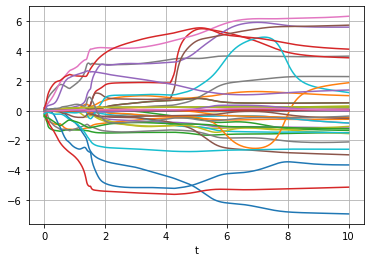

In [183]:
import matplotlib.pyplot as plt
for i in range(coeff*N):
    plt.plot(time_domain, [row[i] for row in Y])
#plt.legend(loc='best')
plt.xlabel('t')
plt.grid()
#plt.ylim(0,10)
plt.show()

In [184]:
obs = [[1.,2]]
obs_1 = [[-1.,1]]


obs_map = [
            ["z", obs], 
            ["z", obs_1], 


]

observable = hamiltonian(obs_map,dynamic_list=[],basis=basis,**no_checks)
observable_matrix = observable.toarray()
observable_matrix_p = observable_matrix
for i in range(LL+1):
    observable_matrix_p = (Proj[i]+Proj_0[i])@observable_matrix_p@(Proj[i]+Proj_0[i])
    
observable_matrix = observable_matrix_p



In [185]:
def var_ansatz(theta,psi_0):
    psi = psi_0
    for i in range(coeff*N):
        psi = R(coeff*N-1-i,theta[coeff*N-1-i])@psi

    return psi

In [186]:
def hamiltonian_evolution(theta):
    return expm(-1j*full_ham_matrix.toarray()*theta)

def hamiltonian_evolution_1(theta):
    return expm(-1j*constrained_full_ham_matrix.toarray()*theta)

In [187]:
psi = var_ansatz(start_point,psi_0)

In [188]:
psi_ground = eigenvec[:,0]


In [189]:
expt_value_u = np.zeros(len(time_domain))
energy = np.zeros(len(time_domain))
psi = var_ansatz(start_point,psi_0)
for tt in range(len(time_domain)):
    theta = []
    for i in range(coeff*N):
        theta.append(Y[tt][i])

    psi_var = var_ansatz(theta,psi_0)
    
    for i in range(LL+1):
        psi_var = (Proj[i]+Proj_0[i])@psi_var
    norm = np.sqrt(np.real(np.conj(psi_var)@psi_var))

    expt_value_u[tt] = np.abs(np.conj(psi_var)@psi_ground/norm)**2
    energy[tt] = np.real(np.conj(psi_var)@full_ham_matrix@psi_var/norm**2)


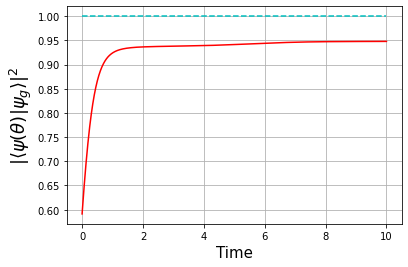

In [190]:
plt.plot(time_domain,expt_value_u, color = "red")
plt.plot(time_domain,1.*np.ones(len(time_domain)), ls = "--", color ="c")

plt.ylabel(r"$|\langle \psi(\theta)|\psi_g\rangle|^2$",size = 18)
plt.xlabel('Time',size = 15)
plt.grid()
#plt.xlim(0,10)
#plt.ylim(0.94,0.98)

#plt.savefig("Imaginary_time_evolution_fidelity_2d_1plaquette_M=0.1_N=3.pdf",bbox_inches = "tight")

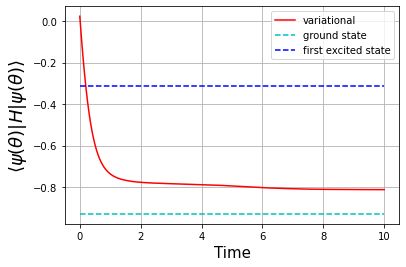

In [191]:
plt.plot(time_domain,energy, color = "red",label = "variational")
plt.plot(time_domain,eigenval[0]*np.ones(len(time_domain)), ls = "--", color ="c", label = "ground state")
plt.plot(time_domain,eigenval[1]*np.ones(len(time_domain)), ls = "--", color ="b", label = "first excited state")

plt.ylabel(r"$\langle \psi(\theta)|H|\psi(\theta)\rangle$",size = 18)
plt.xlabel('Time',size = 15)
plt.grid()
#plt.xlim(0,10)
plt.legend()
#plt.ylim(0.9,0.95)

#plt.savefig("Imaginary_time_evolution_energy_2d_1plaquette_M=0.1_N=3.pdf",bbox_inches = "tight")

In [192]:
print(expt_value_u[-1])

0.9479853604494796


In [ ]:
a = np.array([1,2,4])
ind = [1,3,5]
for i in ind:
    a = np.insert(a,i,i)
    print(a)

In [33]:
vec = np.array([1,2,3,4,5])
print(vec[-1]-vec[0])

4
